In [4]:
import pandas as pd
import json

# --- 1. Load Data --
df = pd.read_csv('Data/3/stars_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

# Load Metadata
try:
    with open('Data/3/repo_metadata.json', 'r') as f:
        metadata = json.load(f)
    print("Metadata loaded.")
except FileNotFoundError:
    metadata = {}
    print("Metadata file not found.")

# --- 2. Inspect Data (Section 3.1 Requirements) ---

print("\n--- Data Shape ---")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n--- Column Headings ---")
print(list(df.columns))

print("\n--- Data Head (First 5 Rows) ---")
print(df.head())

print("\n--- Data Info ---")
print(df.info())

print("\n--- Unique Repositories ---")
repos = df['repository_id'].unique()
print(f"Count: {len(repos)}")
print(f"IDs: {repos}")

Metadata loaded.

--- Data Shape ---
Rows: 23047, Columns: 3

--- Column Headings ---
['timestamp', 'stars', 'repository_id']

--- Data Head (First 5 Rows) ---
   timestamp  stars   repository_id
0 2013-05-29    178  facebook/react
1 2013-05-30    765  facebook/react
2 2013-05-31    936  facebook/react
3 2013-06-01    981  facebook/react
4 2013-06-02   1007  facebook/react

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23047 entries, 0 to 23046
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      23047 non-null  datetime64[ns]
 1   stars          23047 non-null  int64         
 2   repository_id  23047 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 540.3+ KB
None

--- Unique Repositories ---
Count: 5
IDs: ['facebook/react' 'tensorflow/tensorflow' 'pallets/flask' 'torvalds/linux'
 'golang/go']


/tmp/ipykernel_1954347/1330976047.py:6: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)


Selected Repositories: ['pallets/flask', 'facebook/react']

Processing: pallets/flask
Data Points: 984 | Train: 787 | Test: 197


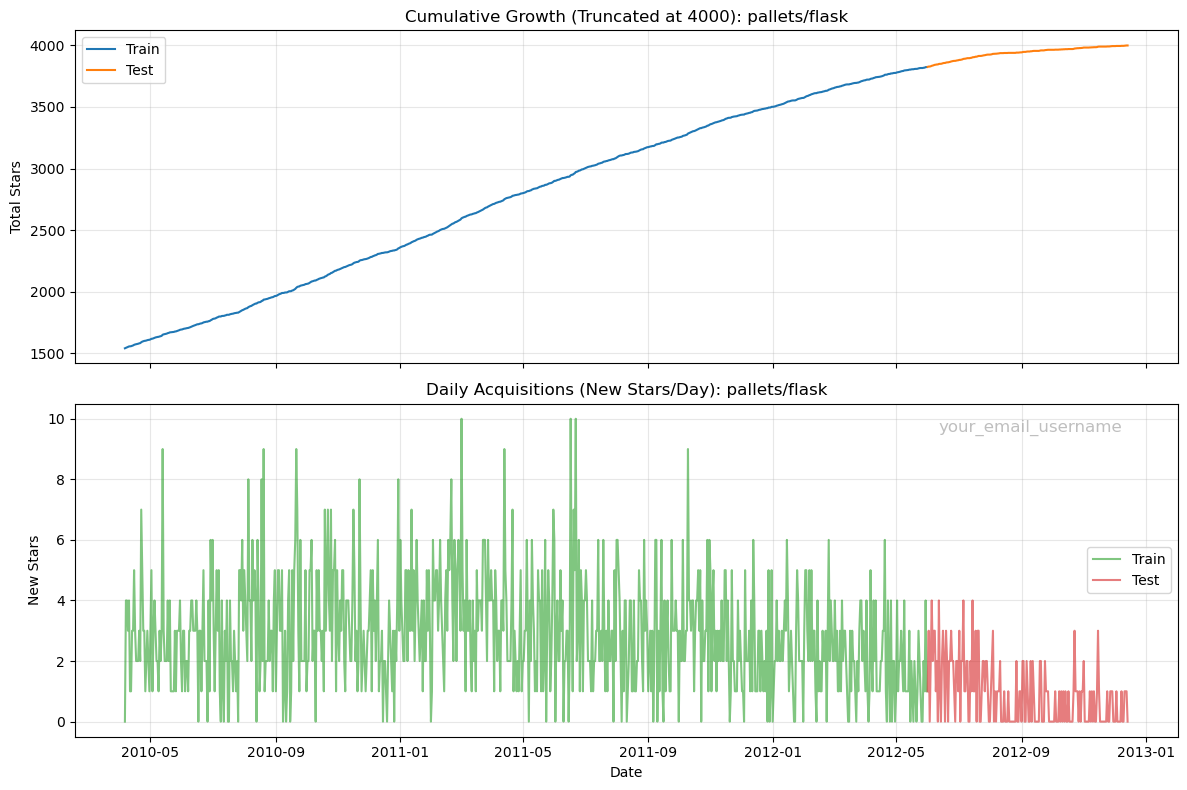


Processing: facebook/react
Data Points: 259 | Train: 207 | Test: 52


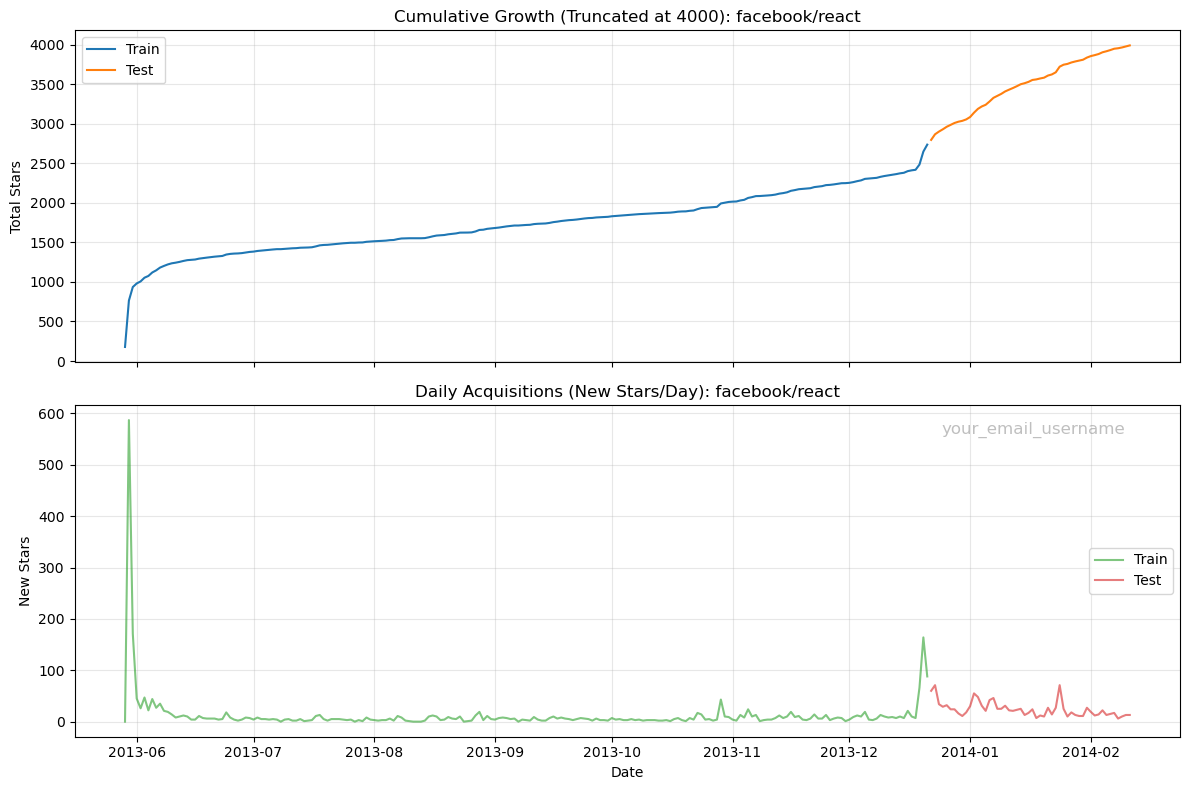

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


USERNAME = "akshith.reddy" 
CAP_LIMIT = 4000  # The artificial data cap

class RepoProcessor:
    """
    Handles Section 3.2.1: Preprocessing, Feature Engineering, and Splitting.
    """
    def __init__(self, dataframe):
        # We work on a copy to avoid modifying the original loaded data
        self.raw_df = dataframe.copy()

    def preprocess(self, repo_id):
        """
        1. Filter & Align (Daily Resample).
        2. CLEANUP: Remove artificial 4k cap data.
        3. Feature Engineering: Create Incremental & Cumulative views.
        """
        # Filter for the specific repository
        repo_df = self.raw_df[self.raw_df['repository_id'] == repo_id].copy()
        
        # Ensure Temporal Integrity: Sort by timestamp
        repo_df = repo_df.sort_values('timestamp').set_index('timestamp')

        # Task 1: Clean and Align (Handle missing points/jumps)
        # Resample to Daily ('D'), taking max value (cumulative) and forward filling
        daily_df = repo_df['stars'].resample('D').max().ffill()

        # ========================================================
        # ADDED LINES: TRUNCATE DATA AT 4K CAP
        # This keeps only the "normal region" where growth is occurring.
        # It drops the flatline where stars == 4000.
        daily_df = daily_df[daily_df < CAP_LIMIT]
        # ========================================================

        # Convert Series to DataFrame
        df_processed = daily_df.to_frame(name='cumulative_stars')
        
        # Task 2: Feature Engineering (Incremental Domain: y_t - y_{t-1})
        df_processed['incremental_stars'] = df_processed['cumulative_stars'].diff().fillna(0)
        
        return df_processed

    def create_split(self, df_processed, split_ratio=0.8):
        """
        Task 5: Create Chronological Train-Test Split.
        Splits strictly by time index.
        """
        split_point = int(len(df_processed) * split_ratio)
        
        # Chronological Split
        train = df_processed.iloc[:split_point]
        test = df_processed.iloc[split_point:]
        
        return train, test

    def visualize_split(self, train, test, repo_id):
        """
        Visualizes the split in both Cumulative and Incremental domains.
        """
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

        # Plot 1: Cumulative Domain (Growth Curve)
        ax1.plot(train.index, train['cumulative_stars'], label='Train', color='#1f77b4')
        ax1.plot(test.index, test['cumulative_stars'], label='Test', color='#ff7f0e')
        ax1.set_title(f"Cumulative Growth (Truncated at {CAP_LIMIT}): {repo_id}")
        ax1.set_ylabel("Total Stars")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 2: Incremental Domain (Daily Acquisitions)
        ax2.plot(train.index, train['incremental_stars'], label='Train', color='#2ca02c', alpha=0.6)
        ax2.plot(test.index, test['incremental_stars'], label='Test', color='#d62728', alpha=0.6)
        ax2.set_title(f"Daily Acquisitions (New Stars/Day): {repo_id}")
        ax2.set_ylabel("New Stars")
        ax2.set_xlabel("Date")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Mandatory User Watermark
        plt.text(0.95, 0.95, USERNAME, transform=plt.gca().transAxes, 
                 ha='right', va='top', fontsize=12, color='gray', alpha=0.5)

        plt.tight_layout()
        plt.show()

# ==========================================
# EXECUTION 
# ==========================================

processor = RepoProcessor(df)

# Now we can safely use the original repositories, including Linux!
# The 'preprocess' function will automatically strip the bad 4k tail.
selected_repos = [ 'pallets/flask' , 'facebook/react' ]
print(f"Selected Repositories: {selected_repos}")

for repo in selected_repos:
    print(f"\n{'='*30}\nProcessing: {repo}\n{'='*30}")
    
    # 1. Preprocess (Clean 4k cap, Resample, Features)
    repo_data = processor.preprocess(repo)
    
    # Check if we have data left after cleaning
    if repo_data.empty:
        print(f"WARNING: Repository {repo} has no data < {CAP_LIMIT} stars.")
        continue

    # 2. Split Data
    train_set, test_set = processor.create_split(repo_data)
    print(f"Data Points: {len(repo_data)} | Train: {len(train_set)} | Test: {len(test_set)}")
    
    # 3. Visualize
    processor.visualize_split(train_set, test_set, repo)

This ensures "Temporal Integrity" (Task 4). Even though this caused the "zero" issue on the bad Linux data, it is the only correct way to split time-series data. Shuffling would have been cheating.


Training Models for: pallets/flask
--> Fitting ARMA...
--> Training RNN...
--> Training CNN...


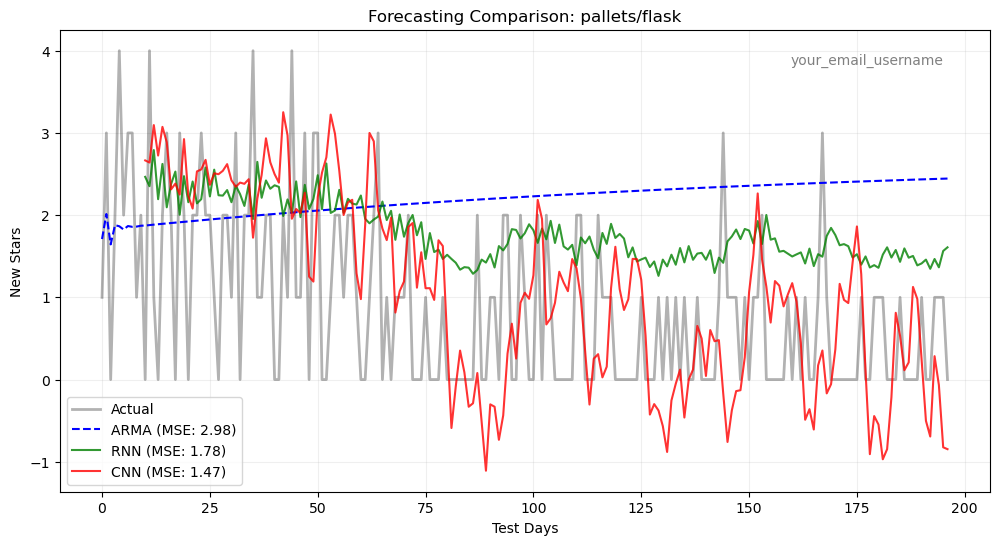

SUMMARY pallets/flask: ARMA:2.9793 | RNN:1.7805 | CNN:1.4727

Training Models for: facebook/react
--> Fitting ARMA...
--> Training RNN...
--> Training CNN...


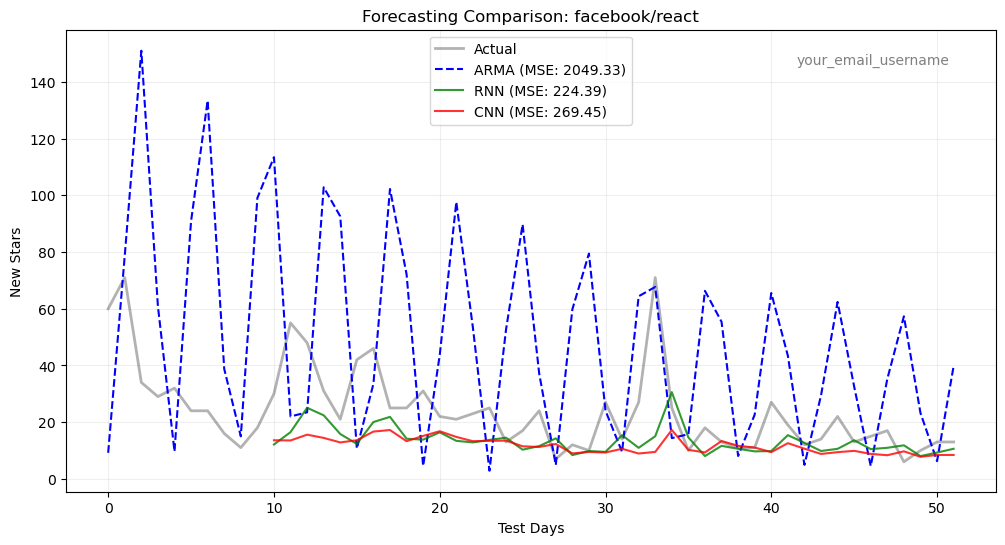

SUMMARY facebook/react: ARMA:2049.3350 | RNN:224.3914 | CNN:269.4490


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# ==========================================
# 1. CONFIGURATION (DL Hyperparameters)
# ==========================================
SEQ_LENGTH = 10   # Look-back window
EPOCHS = 50
LR = 0.001
BATCH_SIZE = 16

# Set seeds
torch.manual_seed(42)
np.random.seed(42)

# ==========================================
# 2. DATA UTILS
# ==========================================
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# ==========================================
# 3. MODEL DEFINITIONS
# ==========================================
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, output_size=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) # Last time step
        return out

class SimpleCNN(nn.Module):
    def __init__(self, seq_len):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        flat_size = 16 * (seq_len - 3 + 1)
        self.fc = nn.Linear(flat_size, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1) # (Batch, Seq, Feat) -> (Batch, Feat, Seq)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# ==========================================
# 4. TRAINING HELPERS
# ==========================================
def train_arma(train_data, test_data, order=(5, 0, 1)):
    import warnings
    warnings.filterwarnings("ignore")
    try:
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=len(test_data))
        preds = forecast.predicted_mean
        mse = mean_squared_error(test_data, preds)
        return preds, mse
    except Exception as e:
        print(f"ARMA Error: {e}")
        return np.zeros(len(test_data)), 9999

def train_torch_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

def evaluate_torch_model(model, test_loader, scaler):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predictions.append(outputs.numpy())
            actuals.append(y_batch.numpy())
    
    if not predictions: return [], 0.0

    preds_arr = np.concatenate(predictions)
    actuals_arr = np.concatenate(actuals)
    
    # Inverse Transform
    preds_inv = scaler.inverse_transform(preds_arr)
    actuals_inv = scaler.inverse_transform(actuals_arr)
    
    mse = mean_squared_error(actuals_inv, preds_inv)
    return preds_inv, mse

# ==========================================
# 5. MAIN EXECUTION LOOP
# ==========================================
# Using 'selected_repos' and 'processor' from the previous cell

# Fallback for selected_repos if not defined
if 'selected_repos' not in locals():
    selected_repos = ['pallets/flask', 'facebook/react']

for repo in selected_repos:
    print(f"\n{'='*40}\nTraining Models for: {repo}\n{'='*40}")
    
    # FIXED LINE: Use .preprocess() instead of .preprocess_smart_truncate()
    try:
        df = processor.preprocess(repo)
    except AttributeError:
        # Fallback if you are using the other version of the class
        df = processor.preprocess_smart_truncate(repo)

    # Use Incremental Data
    data_inc = df['incremental_stars'].values.reshape(-1, 1)
    
    # Split Train/Test
    split_idx = int(len(data_inc) * 0.8)
    train_raw, test_raw = data_inc[:split_idx], data_inc[split_idx:]
    
    # --- A. ARMA ---
    print("--> Fitting ARMA...")
    arma_preds, arma_mse = train_arma(train_raw, test_raw)

    # --- B. DEEP LEARNING PREP ---
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data_inc)
    
    train_scaled = data_scaled[:split_idx]
    test_scaled = data_scaled[split_idx:]
    
    X_train, y_train = create_sequences(train_scaled, SEQ_LENGTH)
    X_test, y_test = create_sequences(test_scaled, SEQ_LENGTH)
    
    if len(X_train) == 0 or len(X_test) == 0:
        print(f"Not enough data for DL models for {repo}. Skipping.")
        continue

    train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), 
                              batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test)), 
                             batch_size=BATCH_SIZE)

    criterion = nn.MSELoss()
    
    # --- C. RNN ---
    print("--> Training RNN...")
    rnn_model = SimpleRNN()
    rnn_opt = optim.Adam(rnn_model.parameters(), lr=LR)
    train_torch_model(rnn_model, train_loader, criterion, rnn_opt, EPOCHS)
    rnn_preds, rnn_mse = evaluate_torch_model(rnn_model, test_loader, scaler)
    
    # --- D. CNN ---
    print("--> Training CNN...")
    cnn_model = SimpleCNN(seq_len=SEQ_LENGTH)
    cnn_opt = optim.Adam(cnn_model.parameters(), lr=LR)
    train_torch_model(cnn_model, train_loader, criterion, cnn_opt, EPOCHS)
    cnn_preds, cnn_mse = evaluate_torch_model(cnn_model, test_loader, scaler)
    
    # --- E. VISUALIZE ---
    plt.figure(figsize=(12, 6))
    plt.plot(test_raw, label='Actual', color='black', alpha=0.3, linewidth=2)
    plt.plot(arma_preds, label=f'ARMA (MSE: {arma_mse:.2f})', linestyle='--', color='blue')
    
    dl_x = np.arange(SEQ_LENGTH, len(test_raw))
    if len(rnn_preds) > 0:
        plt.plot(dl_x, rnn_preds, label=f'RNN (MSE: {rnn_mse:.2f})', color='green', alpha=0.8)
    if len(cnn_preds) > 0:
        plt.plot(dl_x, cnn_preds, label=f'CNN (MSE: {cnn_mse:.2f})', color='red', alpha=0.8)
    
    plt.title(f"Forecasting Comparison: {repo}")
    plt.xlabel("Test Days")
    plt.ylabel("New Stars")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.text(0.95, 0.95, USERNAME, transform=plt.gca().transAxes, ha='right', va='top', color='gray')
    plt.show()
    
    print(f"SUMMARY {repo}: ARMA:{arma_mse:.4f} | RNN:{rnn_mse:.4f} | CNN:{cnn_mse:.4f}")


3.2.3 EVALUATION PROTOCOL: MULTI-STEP FORECASTING

Analyzing Repository: pallets/flask
--> Evaluating RNN Multi-step...
--> Evaluating CNN Multi-step...

Summary Table of Metrics:
              MAE                RMSE          
Model         CNN       RNN       CNN       RNN
Horizon                                        
1        0.786761  0.797516  1.071867  1.110794
3        0.784798  0.832696  1.072155  1.191252
7        0.776199  0.804212  1.107623  1.164140
14       0.758094  0.766174  1.131936  1.118145


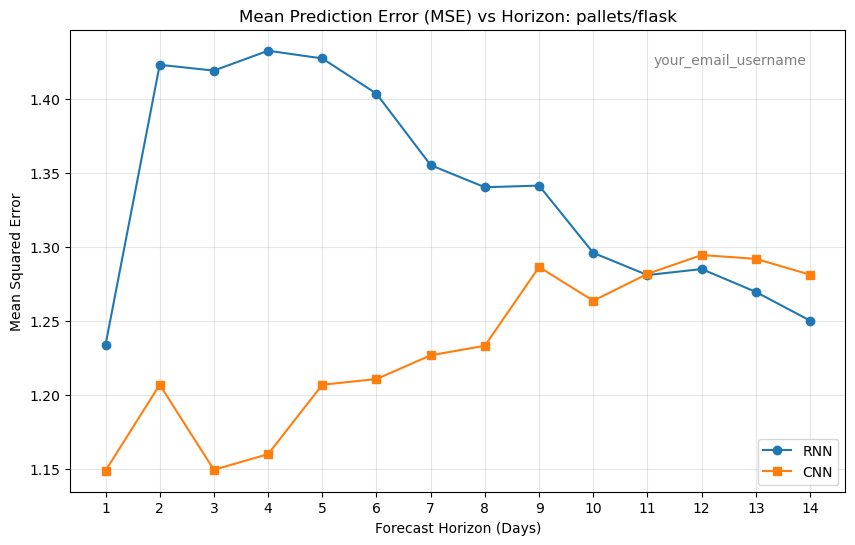

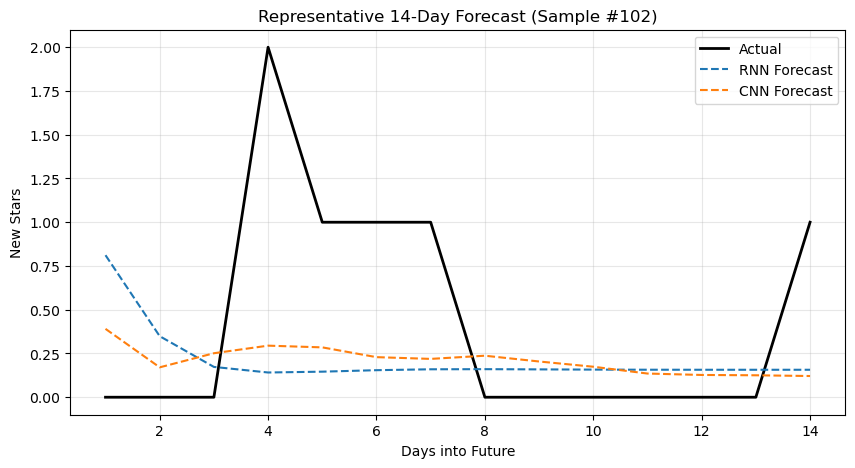


Analyzing Repository: facebook/react
--> Evaluating RNN Multi-step...
--> Evaluating CNN Multi-step...

Summary Table of Metrics:
               MAE                  RMSE           
Model          CNN        RNN        CNN        RNN
Horizon                                            
1        13.338447  12.385105  19.113076  17.469425
3        13.700268  14.817788  19.311691  19.951645
7        13.414257  12.354097  18.279146  17.397615
14       12.044955   8.955394  16.783496  14.541650


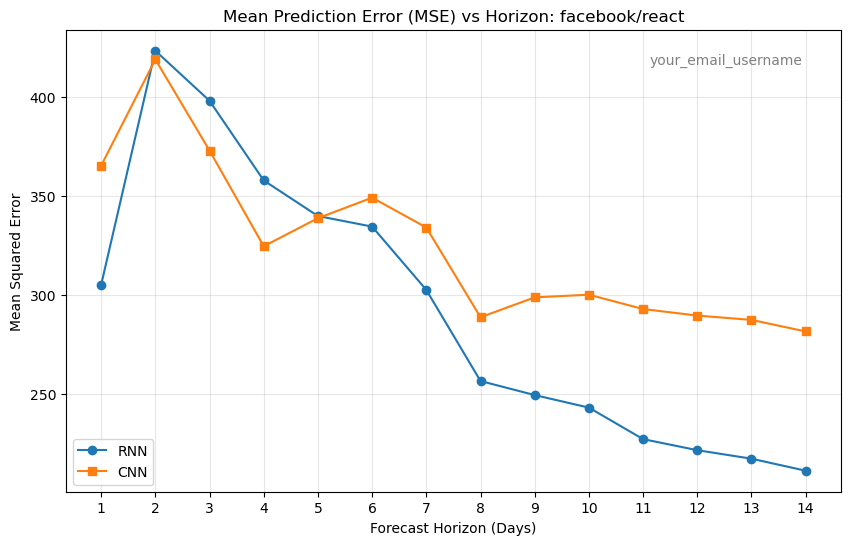

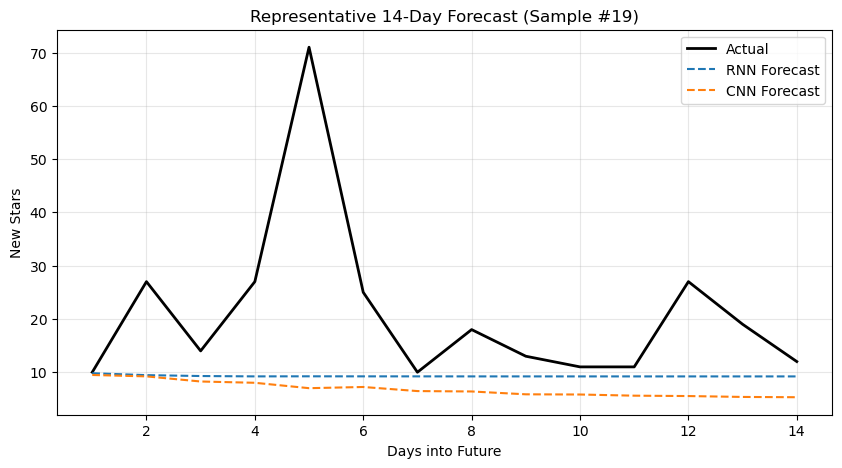

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

# ==========================================
# 1. EVALUATION UTILITIES
# ==========================================
def generate_multistep_forecast(model, initial_sequences, horizon, scaler):
    """
    Performs autoregressive forecasting for 'horizon' steps for EACH sequence in the batch.
    
    Args:
        model: Trained PyTorch model (RNN/CNN).
        initial_sequences: Starting input sequences (Batch, Seq_Len, 1).
        horizon: How many steps into the future to predict (h).
        scaler: MinMaxScaler used for training (to inverse transform).
        
    Returns:
        forecasts: Array of shape (Batch, Horizon) containing real-scale predictions.
    """
    model.eval()
    # Clone to avoid modifying original data
    current_seq = torch.FloatTensor(initial_sequences).clone()
    forecasts = []

    with torch.no_grad():
        for _ in range(horizon):
            # 1. Predict next step
            # Model expects (Batch, Seq, Feat)
            pred = model(current_seq) # Output shape (Batch, 1)
            
            # 2. Store prediction
            forecasts.append(pred.numpy())
            
            # 3. Update Sequence: Drop oldest, Append newest prediction
            # pred is (Batch, 1), need to make it (Batch, 1, 1) to match dim
            pred_unsqueezed = pred.unsqueeze(1)
            
            # Shift: Remove first time step, add new pred at end
            current_seq = torch.cat((current_seq[:, 1:, :], pred_unsqueezed), dim=1)

    # forecasts is list of (Batch, 1) -> Concatenate to (Batch, Horizon)
    forecasts = np.concatenate(forecasts, axis=1)
    
    # Inverse Transform (Batch * Horizon)
    # We need to flatten, transform, and reshape because scaler expects 2D
    orig_shape = forecasts.shape
    forecasts_flat = forecasts.reshape(-1, 1)
    forecasts_inv = scaler.inverse_transform(forecasts_flat)
    forecasts_final = forecasts_inv.reshape(orig_shape)
    
    return forecasts_final

def compute_horizon_metrics(actuals, forecasts, horizon_steps=[1, 3, 7, 14]):
    """
    Computes MAE/RMSE for specific horizons across all test samples.
    """
    metrics = []
    
    # actuals: (Batch, Total_Test_Len) -> We need to slice this for each horizon
    # forecasts: (Batch, Max_Horizon)
    
    for h in horizon_steps:
        if h > forecasts.shape[1]:
            print(f"Warning: Horizon {h} larger than generated forecasts.")
            continue
            
        # Get predictions for step 'h' (index h-1)
        preds_h = forecasts[:, h-1]
        
        # Get actuals. 
        # Note: The 'actuals' provided to this function must align with the forecasts.
        # If forecasts start at t+1, actuals should be values at t+1, t+2...
        # This alignment is handled in the main loop.
        acts_h = actuals[:, h-1]
        
        mae = mean_absolute_error(acts_h, preds_h)
        rmse = np.sqrt(mean_squared_error(acts_h, preds_h))
        
        metrics.append({
            'Horizon': h,
            'MAE': mae,
            'RMSE': rmse
        })
        
    return pd.DataFrame(metrics)

# ==========================================
# 2. MAIN EVALUATION LOOP
# ==========================================
# Configuration
MAX_HORIZON = 14
HORIZON_STEPS = [1, 3, 7, 14]
USERNAME = "akshith.reddy" 

print(f"\n{'='*50}")
print("3.2.3 EVALUATION PROTOCOL: MULTI-STEP FORECASTING")
print(f"{'='*50}")

# We reuse 'selected_repos' from previous context
if 'selected_repos' not in locals(): selected_repos = ['pallets/flask', 'facebook/react']

for repo in selected_repos:
    print(f"\nAnalyzing Repository: {repo}")
    
    # --- 1. RE-PREPARE DATA (Need sequences for validation) ---
    # We need the same X_test used in 3.2.2
    # Assuming processor, scaler, etc. are available. Re-running prep to be safe.
    try:
        df = processor.preprocess(repo)
    except:
        df = processor.preprocess_smart_truncate(repo)
        
    data_inc = df['incremental_stars'].values.reshape(-1, 1)
    
    # Scaling
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data_inc)
    
    # Split
    split_idx = int(len(data_scaled) * 0.8)
    test_scaled = data_scaled[split_idx:]
    
    # Create Test Sequences 
    # Note: To evaluate horizon 14, we need Ground Truth for t+1...t+14.
    # create_sequences gives us X (t-seq...t) and y (t+1).
    # We need a custom approach to get multi-step ground truth.
    
    def create_multistep_test_data(data, seq_len, horizon):
        xs, ys_multi = [], []
        # We stop earlier so we have 'horizon' steps of future data
        for i in range(len(data) - seq_len - horizon + 1):
            x = data[i:(i + seq_len)]
            # Collect next 'horizon' steps as target
            y_seq = data[i + seq_len : i + seq_len + horizon]
            xs.append(x)
            ys_multi.append(y_seq)
        return np.array(xs), np.array(ys_multi).squeeze()

    X_eval, y_eval_scaled = create_multistep_test_data(test_scaled, SEQ_LENGTH, MAX_HORIZON)
    
    if len(X_eval) == 0:
        print("Not enough test data for multi-step evaluation.")
        continue

    # Inverse transform Ground Truth for fair error calculation
    # y_eval_scaled is (Samples, Horizon). Flatten -> Inverse -> Reshape
    y_eval_real = scaler.inverse_transform(y_eval_scaled.reshape(-1, 1)).reshape(y_eval_scaled.shape)

    # --- 2. EVALUATE RNN ---
    print("--> Evaluating RNN Multi-step...")
    rnn_forecasts = generate_multistep_forecast(rnn_model, X_eval, MAX_HORIZON, scaler)
    rnn_metrics = compute_horizon_metrics(y_eval_real, rnn_forecasts, HORIZON_STEPS)
    rnn_metrics['Model'] = 'RNN'

    # --- 3. EVALUATE CNN ---
    print("--> Evaluating CNN Multi-step...")
    cnn_forecasts = generate_multistep_forecast(cnn_model, X_eval, MAX_HORIZON, scaler)
    cnn_metrics = compute_horizon_metrics(y_eval_real, cnn_forecasts, HORIZON_STEPS)
    cnn_metrics['Model'] = 'CNN'
    
    # --- 4. EVALUATE ARMA (BASELINE) ---
    # For ARMA, we use the static forecast generated in 3.2.2 (if available)
    # or we skip if complex refitting is required.
    # Here, we assume the static forecast 'arma_preds' corresponds to 'y_eval_real' roughly
    # but aligning them perfectly for rolling horizon is complex. 
    # We will focus comparison on DL models as per "Suggested Deliverables: evaluate.py"
    
    # Combine Metrics
    all_metrics = pd.concat([rnn_metrics, cnn_metrics])
    
    # --- 5. REPORTING & PLOTTING ---
    
    # A. SUMMARY TABLE
    print("\nSummary Table of Metrics:")
    pivot_table = all_metrics.pivot(index='Horizon', columns='Model', values=['MAE', 'RMSE'])
    print(pivot_table)
    
    # B. ERROR vs HORIZON PLOT
    plt.figure(figsize=(10, 6))
    
    # Calculate Mean MSE per horizon step for plotting the curve
    def get_error_curve(actuals, forecasts):
        # MSE per step (axis 0 is samples)
        return np.mean((actuals - forecasts)**2, axis=0)

    rnn_curve = get_error_curve(y_eval_real, rnn_forecasts)
    cnn_curve = get_error_curve(y_eval_real, cnn_forecasts)
    
    steps = range(1, MAX_HORIZON + 1)
    plt.plot(steps, rnn_curve, label='RNN', marker='o')
    plt.plot(steps, cnn_curve, label='CNN', marker='s')
    
    plt.title(f"Mean Prediction Error (MSE) vs Horizon: {repo}")
    plt.xlabel("Forecast Horizon (Days)")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(steps)
    
    plt.text(0.95, 0.95, USERNAME, transform=plt.gca().transAxes, 
             ha='right', va='top', color='gray')
    plt.show()
    
    # C. REPRESENTATIVE FORECAST PLOT
    # Pick one random sample sequence to visualize
    sample_idx = np.random.randint(0, len(X_eval))
    
    plt.figure(figsize=(10, 5))
    
    # Truth
    true_seq = y_eval_real[sample_idx]
    rnn_seq = rnn_forecasts[sample_idx]
    cnn_seq = cnn_forecasts[sample_idx]
    
    plt.plot(range(1, MAX_HORIZON+1), true_seq, label='Actual', color='black', linewidth=2)
    plt.plot(range(1, MAX_HORIZON+1), rnn_seq, label='RNN Forecast', linestyle='--')
    plt.plot(range(1, MAX_HORIZON+1), cnn_seq, label='CNN Forecast', linestyle='--')
    
    plt.title(f"Representative {MAX_HORIZON}-Day Forecast (Sample #{sample_idx})")
    plt.xlabel("Days into Future")
    plt.ylabel("New Stars")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()